In [1]:
import h5py

def list_contents(h5_file):
    with h5py.File(h5_file, 'r') as file:
        print("Listing all groups and datasets within the file:")
        file.visititems(print_name_and_info)

def print_name_and_info(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(f"Dataset: {name} - Shape: {obj.shape}, Dtype: {obj.dtype}")
    else:
        print(f"Group: {name}")

def check_data_in_h5(file_path):
    with h5py.File(file_path, 'r') as f:
        for name in f:
            print(name, f[name]['true_vol'][:].sum())  # Check if the volume contains non-zero values

def view_dataset(h5_file, dataset_path):
    with h5py.File(h5_file, 'r') as file:
        if dataset_path in file:
            data = file[dataset_path][()]
            print(f"Data from {dataset_path}:")
            print(data)
        else:
            print(f"Dataset {dataset_path} not found in file.")

h5_file = 'cryo_data_rmsd.h5'
#check_data_in_h5('cryo_data.h5')

# List all groups and datasets
list_contents(h5_file)

# View specific dataset (replace 'group/dataset' with actual path in your H5 file)
view_dataset(h5_file, 'group/dataset')


Listing all groups and datasets within the file:
Group: 2Y9J_backbone
Dataset: 2Y9J_backbone/homolog_ca - Shape: (64, 64, 64), Dtype: float32
Dataset: 2Y9J_backbone/true_ca - Shape: (64, 64, 64), Dtype: float32
Dataset: 2Y9J_backbone/true_vol - Shape: (64, 64, 64), Dtype: float32
Group: 2YEW_backbone
Dataset: 2YEW_backbone/homolog_ca - Shape: (64, 64, 64), Dtype: float32
Dataset: 2YEW_backbone/true_ca - Shape: (64, 64, 64), Dtype: float32
Dataset: 2YEW_backbone/true_vol - Shape: (64, 64, 64), Dtype: float32
Group: 3IXV_backbone
Dataset: 3IXV_backbone/homolog_ca - Shape: (64, 64, 64), Dtype: float32
Dataset: 3IXV_backbone/true_ca - Shape: (64, 64, 64), Dtype: float32
Dataset: 3IXV_backbone/true_vol - Shape: (64, 64, 64), Dtype: float32
Group: 3IYJ_backbone
Dataset: 3IYJ_backbone/homolog_ca - Shape: (64, 64, 64), Dtype: float32
Dataset: 3IYJ_backbone/true_ca - Shape: (64, 64, 64), Dtype: float32
Dataset: 3IYJ_backbone/true_vol - Shape: (64, 64, 64), Dtype: float32
Group: 3IZI_backbone
Da

In [6]:
import torch
from torch.utils.data import Dataset
import h5py
from torch.utils.data import DataLoader, random_split


class CryoData(Dataset):
    def __init__(self, h5_file):
        self.h5_file = h5_file
        with h5py.File(self.h5_file, 'r') as file:
            self.keys = list(file.keys())

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as file:
            group = file[self.keys[idx]]
            true_ca = torch.tensor(group['true_ca'][:])
            homolog_ca = torch.tensor(group['homolog_ca'][:])
            true_vol = torch.tensor(group['true_vol'][:])
        return {'true_ca': true_ca, 'homolog_ca': homolog_ca, 'true_vol': true_vol}

# Usage example
dataset = CryoData('cryo_data_rmsd.h5')
dataset_size = len(dataset)
train_size = int(0.9 * dataset_size)  # 90% for training
test_size = dataset_size - train_size  # 10% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Data loaders for both train and test sets
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


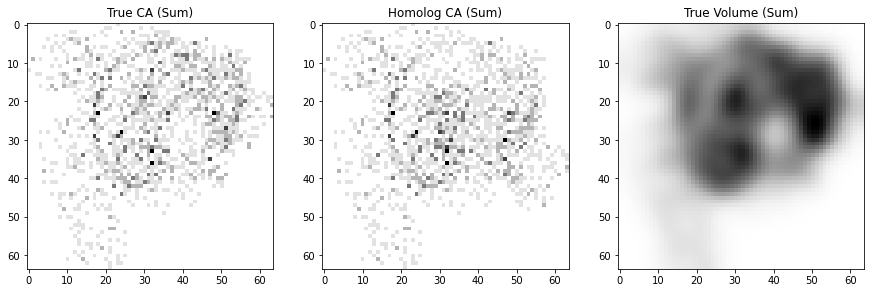

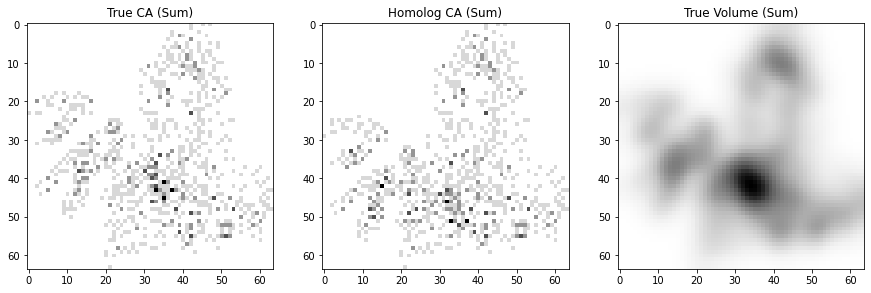

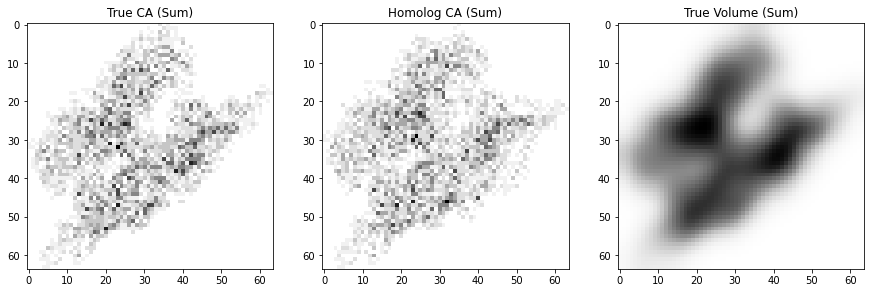

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_data(loader, num_batches=1, start_layer=0, end_layer=63):
    for i, batch in enumerate(loader):
        if i >= num_batches:
            break
        true_ca = batch['true_ca'].numpy()
        homolog_ca = batch['homolog_ca'].numpy()
        true_vol = batch['true_vol'].numpy()

        # Take the sum over the specified range of layers
        true_ca_sum = np.sum(true_ca[:, :, :, start_layer:end_layer+1], axis=3)
        homolog_ca_sum = np.sum(homolog_ca[:, :, :, start_layer:end_layer+1], axis=3)
        true_vol_sum = np.sum(true_vol[:, :, :, start_layer:end_layer+1], axis=3)

        # Visualize the sum over layers
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(true_ca_sum[0], cmap='Greys')
        ax[0].set_title('True CA (Sum)')
        ax[1].imshow(homolog_ca_sum[0], cmap='Greys')
        ax[1].set_title('Homolog CA (Sum)')
        ax[2].imshow(true_vol_sum[0], cmap='Greys')
        ax[2].set_title('True Volume (Sum)')
        plt.show()

# Visualize some data from the train loader
visualize_data(train_loader, num_batches=3)


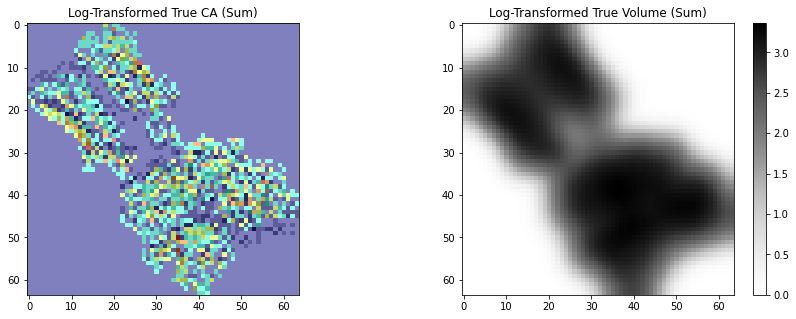

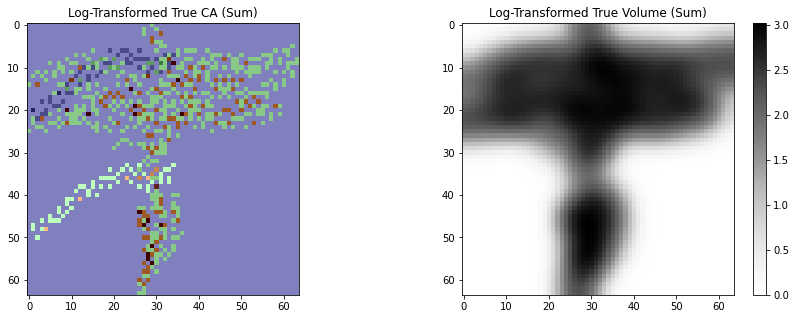

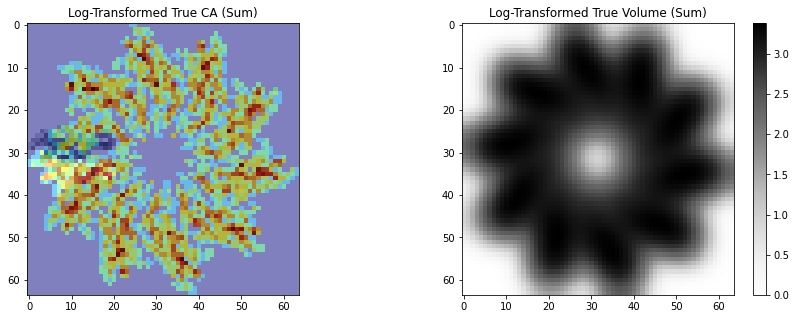

In [9]:
def visualize_data(loader, num_batches=1, start_layer=0, end_layer=63):
    for i, batch in enumerate(loader):
        if i >= num_batches:
            break
        true_ca = batch['true_ca'].numpy()
        homolog_ca = batch['homolog_ca'].numpy()
        true_vol = batch['true_vol'].numpy()

        # Take the sum over the specified range of layers
        true_ca_sum = np.sum(true_ca[:, :, :, start_layer:end_layer+1], axis=3)
        homolog_ca_sum = np.sum(homolog_ca[:, :, :, start_layer:end_layer+1], axis=3)
        true_vol_sum = np.sum(true_vol[:, :, :, start_layer:end_layer+1], axis=3)

        # Apply logarithmic transformation to the data
        true_ca_sum_log = np.log(true_ca_sum + 1)  # Add 1 to avoid log(0)
        homolog_ca_sum_log = np.log(homolog_ca_sum + 1)  # Add 1 to avoid log(0)
        true_vol_sum_log = np.log(true_vol_sum + 1)  # Add 1 to avoid log(0)

        # Create a new figure
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

        # Visualize the log-transformed True CA (sum) with a colormap
        ax[0].imshow(true_ca_sum_log[0], cmap='Greys')
        ax[0].set_title('Log-Transformed True CA (Sum)')

        # Overlay the log-transformed Homolog CA graph on top of True CA with a different colormap
        ax[0].imshow(homolog_ca_sum_log[0], cmap='jet', alpha=0.5)

        # Visualize the log-transformed True Volume (sum)
        ax[1].imshow(true_vol_sum_log[0], cmap='Greys')
        ax[1].set_title('Log-Transformed True Volume (Sum)')

        # Add a colorbar to the plot to indicate the color mapping
        plt.colorbar(ax[1].imshow(true_vol_sum_log[0], cmap='Greys'), ax=ax[1])

        # Show the plot
        plt.show()


# Visualize some data from the train loader
visualize_data(train_loader, num_batches=3)

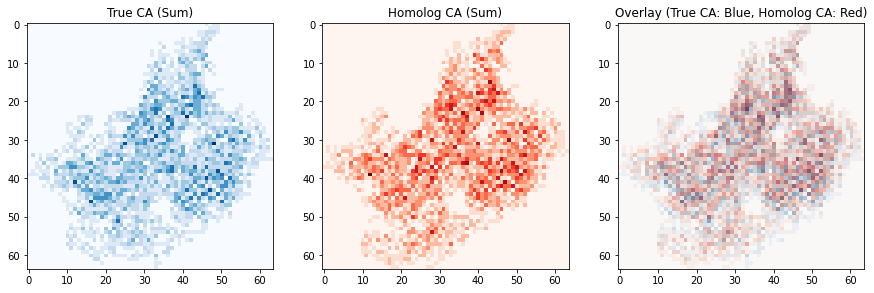

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_data(loader, num_batches=1, start_layer=0, end_layer=63):
    for i, batch in enumerate(loader):
        if i >= num_batches:
            break
        true_ca = batch['true_ca'].numpy()
        homolog_ca = batch['homolog_ca'].numpy()
        true_vol = batch['true_vol'].numpy()

        # Take the sum over the specified range of layers
        true_ca_sum = np.sum(true_ca[:, :, :, start_layer:end_layer+1], axis=3)
        homolog_ca_sum = np.sum(homolog_ca[:, :, :, start_layer:end_layer+1], axis=3)
        true_vol_sum = np.sum(true_vol[:, :, :, start_layer:end_layer+1], axis=3)

        # Create a new figure
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        # Visualize True CA
        ax[0].imshow(true_ca_sum[0], cmap='Blues')
        ax[0].set_title('True CA (Sum)')

        # Visualize Homolog CA
        ax[1].imshow(homolog_ca_sum[0], cmap='Reds')
        ax[1].set_title('Homolog CA (Sum)')

        # Overlay True CA and Homolog CA
        ax[2].imshow(true_ca_sum[0], cmap='Blues')
        ax[2].imshow(homolog_ca_sum[0], cmap='Reds', alpha=0.5)
        ax[2].set_title('Overlay (True CA: Blue, Homolog CA: Red)')

        # Show the plot
        plt.show()

# Example usage
visualize_data(train_loader)
